In [1]:
import pandas as pd
import numpy as np

BASE_PATH = '/opt/ml/input/data/train/'
ratings = pd.read_csv(BASE_PATH + 'train_ratings.csv')
titles = pd.read_csv(BASE_PATH + 'titles.tsv', sep='\t')
genres = pd.read_csv(BASE_PATH + 'genres.tsv', sep='\t')
directors = pd.read_csv(BASE_PATH + 'directors.tsv', sep='\t')
years = pd.read_csv(BASE_PATH + 'years.tsv', sep='\t')
ratings = ratings.drop('time', axis=1)
ratings['rate'] = 1.0

In [2]:
titles[titles.item==2571], titles[titles.item==356]

(   item               title
 1  2571  Matrix, The (1999),
    item                title
 4   356  Forrest Gump (1994))

In [3]:
item2title    = titles.set_index('item')['title'].to_dict()
title2item    = {v: k for k, v in item2title.items()}

item2genre    = genres.set_index('item')['genre'].to_dict()
genre2item    = {v: k for k, v in item2genre.items()}

item2director = directors.set_index('item')['director'].to_dict()
director2item = {v: k for k, v in item2director.items()}

item2year     = years.set_index('item')['year'].to_dict()
year2item     = {v: k for k, v in item2year.items()}

In [4]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(ratings,
                                              stratify=ratings['user'],
                                              random_state=42,
                                              test_size=0.2)

print("N of Train : " , len(ratings_train))
print("N of Test : " , len(ratings_test))

N of Train :  4123576
N of Test :  1030895


In [5]:
ratings_train.item.unique()

array([ 4874,  5952,  1208, ...,  3150,  4241, 45335])

In [6]:
ratings_train.head()

,user,item,rate
1762059,46685,4874,1.0
4082227,109245,5952,1.0
4784205,128351,1208,1.0
1586292,42033,7841,1.0
589954,15703,4226,1.0


In [7]:
def split(data) :
    gr_user_like = data.groupby(['rate', 'user'])
    return ([gr_user_like.get_group(gr)['item'].tolist() for gr in gr_user_like.groups])

In [8]:
from gensim.utils import effective_n_jobs

effective_n_jobs(1)
effective_n_jobs(-1)
effective_n_jobs(None)
effective_n_jobs(12)
effective_n_jobs(10)

10

In [9]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import common_texts, get_tmpfile

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [143]:
len(splitted_movies), sorted(splitted_movies[0])

(31360, True)

In [141]:
sorted(df[df.user==11]['item'].tolist())

[19,
 32,
 39,
 110,
 150,
 153,
 158,
 165,
 170,
 172,
 185,
 208,
 231,
 253,
 256,
 260,
 316,
 318,
 356,
 364,
 377,
 380,
 405,
 410,
 442,
 500,
 527,
 531,
 541,
 551,
 587,
 589,
 592,
 595,
 597,
 610,
 611,
 616,
 648,
 653,
 673,
 736,
 741,
 761,
 780,
 784,
 880,
 968,
 1029,
 1032,
 1036,
 1046,
 1073,
 1196,
 1197,
 1198,
 1200,
 1210,
 1214,
 1240,
 1253,
 1270,
 1274,
 1291,
 1320,
 1321,
 1339,
 1387,
 1527,
 1544,
 1580,
 1584,
 1591,
 1653,
 1676,
 1690,
 1721,
 1748,
 1876,
 1882,
 1961,
 2004,
 2011,
 2012,
 2028,
 2042,
 2105,
 2124,
 2134,
 2140,
 2153,
 2232,
 2240,
 2291,
 2294,
 2313,
 2355,
 2428,
 2455,
 2571,
 2572,
 2600,
 2628,
 2642,
 2716,
 2717,
 2720,
 2722,
 2761,
 2793,
 2810,
 2827,
 2840,
 2858,
 2916,
 2985,
 3000,
 3054,
 3083,
 3113,
 3114,
 3159,
 3247,
 3300,
 3438,
 3525,
 3527,
 3578,
 3697,
 3702,
 3745,
 3752,
 3793,
 3826,
 3863,
 3864,
 3892,
 3897,
 3969,
 3980,
 3988,
 3994,
 4133,
 4226,
 4235,
 4299,
 4306,
 4340,
 4366,
 4446,
 

In [130]:
%%time
splitted_movies = split(ratings_train)
import random
for movie_list in splitted_movies:
    random.shuffle(movie_list)
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences=splitted_movies,
                 epochs=10,      
                 min_count=50,   
                 vector_size=400,
                 workers=9,      
                 sg=1,            
                 hs=0,            
                 negative=10,     
                 window=9999,    
                 seed=42,
                 compute_loss=True,
                 callbacks=[callback()])

print("Time passed: " + str(datetime.datetime.now()-start))
model.save('item2vec_1223')
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_1223')
# word_vectors = model.wv
# word_vectors.cosine_similarities(5954,5952)

Loss after epoch 0: 67836896.0
Loss after epoch 1: 23428528.0
Loss after epoch 2: 22496712.0
Loss after epoch 3: 20455592.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Time passed: 2:00:26.472649
CPU times: user 15h 51min 58s, sys: 3.56 s, total: 15h 52min 1s
Wall time: 2h 45s


In [301]:
model = Word2Vec.load('item2vec_1222')
model.wv.vectors.shape

(6807, 300)

In [25]:
ret = word_vectors.cosine_similarities(model.wv[0], model.wv.vectors)

In [322]:
idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index

In [68]:
ratings_train = ratings_train.sort_values(by=['user', 'item'])
ratings_test  = ratings_test.sort_values(by=['user', 'item'])

In [73]:
ratings[ratings.user==11].head()

,user,item,rate
0,11,4643,1.0
1,11,170,1.0
2,11,531,1.0
3,11,616,1.0
4,11,2140,1.0


## Inference

In [158]:
from tqdm import tqdm
import pandas as pd
import torch
from scipy.spatial.distance import cosine
from time import time

df = ratings

idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index

users, top_items = [], []
for user in tqdm(df.user.unique()):
    # 유저에 대해 아이템 인덱스 리스트 가져오기
    if user==11: s=time()
    item_indices = df[df['user'] == user]['item']
    if user==11: print(time()-s)
    
    # item2idx를 통해 아이템 임베딩 리스트 가져오기
    if user==11: s=time()
    indices = [item2idx[item] for item in item_indices]
    if user==11: print(time()-s)
    if user==11: s=time()
    item_embeddings = model.wv.vectors[indices] # 1: [model.wv[index] for index in indices]
    if user==11: print(time()-s)

    # 평균 취하기
    if user==11: s=time()
    average_embedding = np.mean(item_embeddings, axis=0)
    if user==11: print(time()-s)
    # 2: average_embedding = torch.mean(torch.stack(item_embeddings), dim=0)

    # 전체 임베딩 리스트를 순회하며 이미 시청한 영화를 제외하고 가장 유사한 10개를 고르기
    # Compute the similarity between the average embedding and each item embedding
    # cosine: distance -> x: x[1] instead of x: -x[1]
    if user==11: s=time()
    similarities = [(idx, cosine(average_embedding, embedding)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices]
    if user==11: print(time()-s)
    # similarities = [(idx, torch.cosine_similarity(average_embedding, embedding, dim=0)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices]

    # Sort the list by similarity
    if user==11: s=time()
    similarities.sort(key=lambda x: x[1])
    if user==11: print(time()-s)

    # Select the top 10 items (excluding items already watched)
    if user==11: s=time()
    top_10 = [idx2item[idx] for idx, similarity in similarities[:10]]
    if user==11: print(time()-s)

    users.append(user)
    top_items.append(top_10)

  0%|          | 0/31360 [00:00<?, ?it/s]

0.00815129280090332


KeyError: 828

In [193]:
submission = pd.DataFrame({'user': users, 'item': top_items}).explode('item')
submission.reset_index(drop=True).to_csv("item2vec_1222.csv")

In [161]:
for x in top_10:
    print(titles[titles.item == x]['title'])

3430    Blade (1998)
Name: title, dtype: object
47    Kill Bill: Vol. 2 (2004)
Name: title, dtype: object
4498    Last Samurai, The (2003)
Name: title, dtype: object
120    Shrek 2 (2004)
Name: title, dtype: object
115    Big Fish (2003)
Name: title, dtype: object
3442    Hook (1991)
Name: title, dtype: object
34    Incredibles, The (2004)
Name: title, dtype: object
2938    Saw (2004)
Name: title, dtype: object
3423    Jumanji (1995)
Name: title, dtype: object
4499    Austin Powers: The Spy Who Shagged Me (1999)
Name: title, dtype: object


In [134]:
# titles[titles.item==2571], titles[titles.item==356]
df[df.user == 11]['item'].apply(lambda x: titles[titles.item == x]['title'].values)

0                            [Planet of the Apes (2001)]
1                                       [Hackers (1995)]
2                            [Secret Garden, The (1993)]
3                               [Aristocats, The (1970)]
4                             [Dark Crystal, The (1982)]
                             ...                        
371                  [Last King of Scotland, The (2006)]
372                 [Lilya 4-Ever (Lilja 4-ever) (2002)]
373                        [Little Miss Sunshine (2006)]
374    [Lord of the Rings: The Return of the King, Th...
375                                     [Memento (2000)]
Name: item, Length: 376, dtype: object

In [29]:
from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_1222')

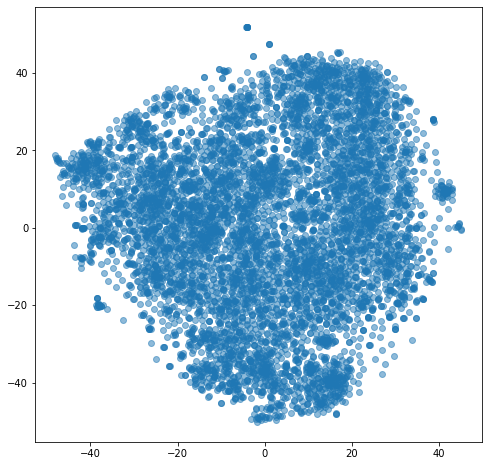

CPU times: user 2min 10s, sys: 1.8 s, total: 2min 12s
Wall time: 26.7 s


In [125]:
%%time
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

tsne    = TSNE(n_components=2, random_state=42)
new_arr = tsne.fit_transform(model.wv.vectors)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.5)

plt.show()

In [126]:
new_arr.shape

(6807, 2)

In [127]:
def get_genre_for_data(idx):
    # assume data is encoded
    item = idx2item[idx]
    return item2genre[item]

idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index

['Crime', 'Drama', 'Action', 'Sci-Fi', 'Thriller', 'Comedy', 'Romance', 'War', 'Adventure', 'Fantasy', 'Horror', 'Mystery', 'Animation', 'Children', 'Film-Noir', 'Musical', 'Western', 'Documentary']


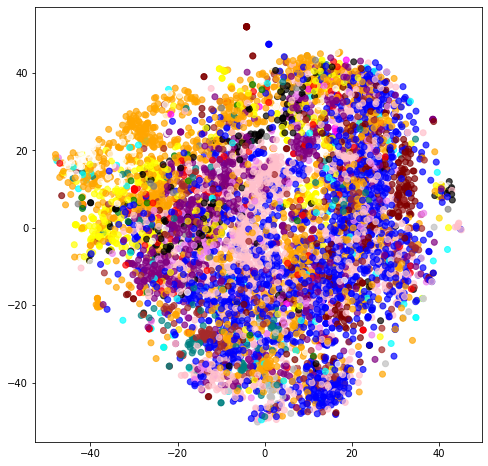

In [128]:
# Create a list of genres
genres_    = genres.genre.unique().tolist()
print(genres_)
# Create a list of colors corresponding to the genres
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black", "white", "cyan", "magenta", "gold", "silver", "violet", "teal", "maroon"]

# Map each genre to a color
genre_to_color = dict(zip(genres_, colors))

# Get the genre for each data point
K = 6807
data_genres = [get_genre_for_data(idx) for idx in range(K)]

# Get the color for each data point
data_colors = [genre_to_color[genre] for genre in data_genres]

# Plot the data with color coding
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.scatter(new_arr[:K, 0], new_arr[:K, 1], c=data_colors, alpha=0.7)
plt.show()


# Playground

In [82]:
context = ratings_train[ratings_train.user==14]['item'].tolist()

In [83]:
outputs = model.predict_output_word(context, topn=10)
outputs

[(356, 0.01231155),
 (6377, 0.009963221),
 (593, 0.009875756),
 (1197, 0.009856051),
 (4886, 0.009601472),
 (2858, 0.007839023),
 (49272, 0.0068332856),
 (150, 0.00562111),
 (2918, 0.005605885),
 (5445, 0.0053876713)]

In [84]:
recommendations = list(map(lambda x: x[0], outputs))

relevants    = set(ratings_test[ratings_test.user==14]['item'].tolist())
interaction  = set(recommendations).intersection(relevants)
recall_at_10 = len(interaction) / len(relevants)
recall_at_10

0.05555555555555555

In [85]:
len(relevants) * 0.02666666666666667

0.9600000000000001

In [73]:
ratings.groupby('user').size()

user
11        376
14        180
18         77
25         91
31        154
         ... 
138473     63
138475    124
138486    137
138492     68
138493    314
Length: 31360, dtype: int64

In [76]:
def cosine_similarity(vec1, vec2): return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index
df       = ratings_train
user     = 14

# 유저에 대해 아이템 인덱스 리스트 가져오기
item_indices = df[df['user'] == user]['item']

# item2idx를 통해 아이템 임베딩 리스트 가져오기
indices = [item2idx[item] for item in item_indices]
item_embeddings = model.wv.vectors[indices]

# 평균 취하기
average_embedding = np.mean(item_embeddings, axis=0)

# 전체 임베딩 리스트를 순회하며 이미 시청한 영화를 제외하고 가장 유사한 10개를 고르기
similarities = ((idx, cosine_similarity(average_embedding, embedding)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices)

# Sort the list by similarity
similarities = list(similarities)
similarities.sort(key=lambda x: x[1])

# Select the top 10 items (excluding items already watched)
top_10 = [idx2item[idx] for idx, similarity in similarities[:10]]

In [77]:
recommendations = top_10

relevants    = set(ratings_test[ratings_test.user==14]['item'].tolist())
interaction  = set(recommendations).intersection(relevants)
recall_at_10 = len(interaction) / len(relevants)
recall_at_10

0.0

In [63]:
len(relevants) * 0.02666666666666667

2.0

In [ ]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

In [199]:
len(splitted_movies), len(splitted_movies[0])

(31360, 301)

# Lab

In [356]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(ratings,
                                               stratify=ratings['user'],
                                               random_state=42,
                                               test_size=0.95)
ratings_train = ratings_train.sort_values(by='user')
ratings_test  = ratings_test.sort_values(by='user')

print("N of Train : " , len(ratings_train))
print("N of Test : " , len(ratings_test))

def rating_splitter(data, ):
    gr_user_like = data.groupby(['rate', 'user'])
    return ([gr_user_like.get_group(gr)['item'].tolist() for gr in gr_user_like.groups])

N of Train :  257723
N of Test :  4896748


In [355]:
ratings_train

,user,item,rate
132,11,1584,1.0
295,11,1527,1.0
283,11,2628,1.0
41,11,1200,1.0
366,11,48516,1.0
...,...,...,...
5154451,138493,5378,1.0
5154249,138493,1441,1.0
5154350,138493,2403,1.0
5154190,138493,7438,1.0


In [347]:
# splitted_movies = rating_splitter(ratings_train)
len(splitted_movies), len(splitted_movies[300])

(31360, 10)

In [350]:
%%time
import random
from gensim.models import Word2Vec
import datetime
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

splitted_movies = rating_splitter(ratings_train)
# for movie_list in splitted_movies:
#     random.shuffle(movie_list)

start = datetime.datetime.now()
model = Word2Vec(sentences=splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 min_count=1, # a movie has to appear more than 10 times to be keeped
                 vector_size=10, # size of the hidden layer
                 workers=5, # specify the number of threads to be used for training
                 sg=1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs=0, # Set to 0, as we are applying negative sampling.
                 negative=1, # If > 0, negative sampling will be used. We will use a value of 5.
                 window=1, # 99999999
                 seed=42,
                 compute_loss=True,
                 callbacks=[callback()])


print("Time passed: " + str(datetime.datetime.now()-start))

model.save('w2v/item2vec_1223_test')
model = Word2Vec.load('w2v/item2vec_1223_test')

Loss after epoch 0: 123142.8046875
Loss after epoch 1: 135208.3671875
Loss after epoch 2: 121672.921875
Loss after epoch 3: 118003.875
Loss after epoch 4: 160033.21875
Time passed: 0:00:00.900450
CPU times: user 6.95 s, sys: 16 ms, total: 6.97 s
Wall time: 6.38 s


In [289]:
model.wv.vectors

array([[ 0.3003091 , -0.31009832, -0.23722696],
       [-0.15122044,  0.21846838, -0.16200535],
       [ 0.21529575,  0.2990996 , -0.16718094],
       [-0.12544572,  0.24601682, -0.05111571],
       [-0.01787424,  0.00788105,  0.17011166]], dtype=float32)

In [290]:
model.wv.index_to_key

['say', 'meme', 'goat', 'hoho', 'cat']

In [291]:
model.wv.most_similar(np.array([ 0.21529575,  0.2990996 , -0.16718094]))

[('goat', 1.0),
 ('hoho', 0.4850040078163147),
 ('meme', 0.47541990876197815),
 ('say', 0.05801837518811226),
 ('cat', -0.4319440424442291)]

In [270]:
len(splitted_movies), len(splitted_movies[0])

(31360, 301)

In [156]:
len(model.wv) #[model.wv.key_to_index[i] for i in inds]

6012

In [136]:
item2idx[352]

KeyError: 352

In [351]:
import numpy as np
from itertools import starmap
from tqdm import tqdm
import pandas as pd
import torch
from scipy.spatial.distance import cosine
from time import time
def cosine_similarity(average_embedding, embedding): return cosine(average_embedding, embedding)
def cosine_similarity(vec1, vec2): return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# train set
df = ratings_train
# splitted_movies

idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index

users_, top_items_ = [], []
longest = 0
for i, user in enumerate(tqdm(df.user.unique())):
    ss=time()
    # 유저에 대해 아이템 인덱스 리스트 가져오기
    if user==11: s=time()
    item_indices = df[df['user'] == user]['item']
    if user==11: print(time()-s)
    
    # item2idx를 통해 아이템 임베딩 리스트 가져오기
    if user==11: s=time()
    indices = [item2idx[item] for item in item_indices]
    if user==11: print(time()-s)
    if user==11: s=time()
    item_embeddings = model.wv.vectors[indices] # 1: [model.wv[index] for index in indices]
    if user==11: print(time()-s)

    # 평균 취하기
    if user==11: s=time()
    average_embedding = np.mean(item_embeddings, axis=0)
    if user==11: print(time()-s)
    # 2: average_embedding = torch.mean(torch.stack(item_embeddings), dim=0)

    # 전체 임베딩 리스트를 순회하며 이미 시청한 영화를 제외하고 가장 유사한 10개를 고르기
    # Compute the similarity between the average embedding and each item embedding
    # cosine: distance -> x: x[1] instead of x: -x[1]
    if user==11: s=time()
    # similarities = [(idx, cosine(average_embedding, embedding)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices]
    similarities = ((idx, cosine_similarity(average_embedding, embedding)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices)
    # 2:39 -> 0:50
    if user==11: print(time()-s)

    # Sort the list by similarity
    if user==11: s=time()
    similarities = list(similarities)
    similarities.sort(key=lambda x: x[1])
    if user==11: print(time()-s)

    # Select the top 10 items (excluding items already watched)
    if user==11: s=time()
    top_10 = [idx2item[idx] for idx, similarity in similarities[:10]]
    if user==11: print(time()-s)

    users_.append(user)
    top_items_.append(top_10)
    
    curr = time()-ss
    if curr > longest:
        longest = curr
        print(i, user, curr)

  0%|          | 4/31360 [00:00<32:45, 15.95it/s]

0 99941 0.0657353401184082


  1%|          | 224/31360 [00:13<31:49, 16.31it/s]

221 24219 0.06809020042419434


  5%|▌         | 1678/31360 [01:40<30:12, 16.38it/s]

1675 91349 0.0681767463684082


  5%|▌         | 1702/31360 [01:42<33:14, 14.87it/s]

1699 113406 0.07301640510559082
1700 72942 0.07523441314697266


  6%|▌         | 1734/31360 [01:44<36:54, 13.38it/s]

1731 8405 0.08697819709777832


  6%|▌         | 1935/31360 [01:57<29:47, 16.46it/s]


KeyboardInterrupt: 

In [117]:
submission = pd.DataFrame({'user': users_, 'item': top_items_}).explode('item')
submission.reset_index(drop=True).to_csv("item2vec_1223.csv", index=False)

In [224]:
# validation

# predict top 10 per user
# get random 10 from ratings_test
# calculate HIT@10

In [234]:
len(top_items), top_items[0]

(31360, [2115, 7438, 1682, 4963, 4886, 8961, 5418, 1265, 47, 733])

In [66]:
relevant_items = []
for user, items in ratings_test.groupby('user')['item']:
    relevant_items.append(items.tolist())

In [68]:
from tqdm import tqdm
recalls = 0.0
# relevant_items: (31360, each_num_valid)
for recommendations, relevants in tqdm(zip(top_items, relevant_items)):
    relevants    = set(relevants)
    intersection = relevants.intersection(recommendations)
    recall_at_k  = len(intersection) / len(relevants)
    recalls     += recall_at_k

print(recalls/31360)

NameError: name 'top_items' is not defined

0.0

## relevants

In [238]:
ratings_test.nunique()

user    31360
item     6807
rate        1
dtype: int64

In [257]:
len(relevant_items), 

(31360,
 [1,
  160,
  173,
  296,
  344,
  367,
  480,
  546,
  586,
  588,
  593,
  608,
  828,
  1028,
  1097,
  1136,
  1225,
  1255,
  1367,
  1391,
  1917,
  2018,
  2396,
  2688,
  2706,
  2762,
  2959,
  3033,
  3269,
  3704,
  3753,
  4054,
  4388,
  4492,
  4638,
  4887,
  4995,
  5152,
  5219,
  5378,
  5463,
  6016,
  6377,
  6378,
  6502,
  6863,
  6996,
  7022,
  7099,
  7173,
  7254,
  7293,
  7845,
  8361,
  8371,
  8810,
  8870,
  8972,
  27368,
  32213,
  34542,
  36509,
  45722,
  46578,
  48304,
  49278,
  52281,
  53000,
  54771,
  57640,
  59315,
  60037,
  63859,
  64614,
  69526])

In [ ]:
def produce_list_of_movieId(list_of_movieName, useRefineSearch=False):
    """
    Turn a list of movie name into a list of movie ids. The movie names has to be exactly the same as they are in the dataset.
    Ambiguous movie names can be supplied if useRefineSearch is set to True
    
    Args:
        list_of_movieName (List): A list of movie names.
        useRefineSearch (boolean): Ambiguous movie names can be supplied if useRefineSearch is set to True

    Returns:
        list_of_movie_id (List of strings): A list of movie ids.
    """
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if useRefineSearch:
            movieName = refine_search(movieName)
            print(movieName)
            print("Refined Name: "+movieName)
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, useRefineSearch=False, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = produce_list_of_movieId(positive_list, useRefineSearch)
    if negative_list:
        negative_list = produce_list_of_movieId(negative_list, useRefineSearch)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [ ]:
from tqdm import tqdm
import pandas as pd
import torch
from scipy.spatial.distance import cosine

df = ratings

idx2item = {i: item for i, item in enumerate(model.wv.index_to_key)}
item2idx = model.wv.key_to_index

users, top_items = [], []
for user in tqdm(df.user.unique()):
    # 유저에 대해 아이템 인덱스 리스트 가져오기
    item_indices = df[df['user'] == user]['item']

    # item2idx를 통해 아이템 임베딩 리스트 가져오기
    indices = [item2idx[item] for item in item_indices]
    item_embeddings = model.wv.vectors[indices]

    # 평균 취하기
    average_embedding = np.mean(item_embeddings, axis=0)

    # 전체 임베딩 리스트를 순회하며 이미 시청한 영화를 제외하고 가장 유사한 10개를 고르기
    similarities = [(idx, cosine(average_embedding, embedding)) for idx, embedding in enumerate(model.wv.vectors) if idx not in indices]

    # Sort the list by similarity
    similarities.sort(key=lambda x: x[1])

    # Select the top 10 items (excluding items already watched)
    top_10 = [idx2item[idx] for idx, similarity in similarities[:10]]

    users.append(user)
    top_items.append(top_10)